In [ ]:
!pip install pydicom

     |████████████████████████████████| 1.9MB 17.9MB/s 


In [ ]:
#importing libraries
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import pydicom
import glob
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.patches import Rectangle
from matplotlib import cm
import os
import seaborn as sns
from skimage import measure
import keras
import tensorflow as tf
import cv2
%matplotlib inline

In [ ]:
#Setting path for directory and files
dataDir = '/content/drive/MyDrive/Capstone'
trainDataDir = 'stage_2_train_images'
testDataDir = 'stage_2_test_images'
trainfiles = glob.glob(os.path.join(dataDir, trainDataDir, "*.dcm"))

In [ ]:
#metadata from dicom training files
image_metadata_df = pd.read_csv('/content/drive/MyDrive/Capstone/patient_info.csv')

In [ ]:
image_metadata_df.drop(columns='Unnamed: 0', inplace=True)

In [ ]:
image_metadata_df.head()

,patientId,age,sex,viewPosition
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,51,F,PA
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,48,F,PA
2,00322d4d-1c29-4943-afc9-b6754be640eb,19,M,AP
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,28,M,PA
4,00436515-870c-4b36-a041-de91049b9ab4,32,F,AP


In [ ]:
print('Storing the DICOM files as a dictionary under trainDicomFiles such that the keys are the patient\
ids and the values are the path of the files corresponding to the image.')
trainDicomFiles = {}
testDicomFiles = {}

for root, dirs, files in os.walk(os.path.join(dataDir, trainDataDir)):
    for fileName in files:
        if '.dcm' in fileName.lower():
            trainDicomFiles[fileName.split(sep='.')[0]] = os.path.join(dataDir, trainDataDir, fileName)     
        
print('\nGenerating the data frame for the training data labels.')
trainLabelDf = pd.read_csv(os.path.join(dataDir, 'stage_2_train_labels.csv'))
trainLabelDetailedDf = pd.read_csv(os.path.join(dataDir, 'stage_2_detailed_class_info.csv'))

# Joining the class information from the detailed class info CSV to the train labels CSV.
trainLabelDf['class'] = trainLabelDetailedDf['class']

# As the training labels file contain multiple rows for each patient corresponding to the number of bounding boxes present
# in case of a person with lung opacity, we can group the labels by patient id to find number of unique patients in 
# the label file.

print('\nGenerating the dictionary for test DICOM files under testDicomFiles.')
for root, dirs, files in os.walk(os.path.join(dataDir, testDataDir)):
    for fileName in files:
        if '.dcm' in fileName.lower():
            testDicomFiles[fileName.split(sep='.')[0]] = os.path.join(dataDir, testDataDir, fileName)

print('Total test data files: ', len(testDicomFiles))

#print('\nBelow is a sample of the content of training label data frame.')
#display(trainLabelDf.head(10))

print('\nAs the training label data frame may contain multiple records for a patient to represent the bounding box, we can \
store the bounding box labels in a property called boundingBox that contains a array of box data stored as \
{x, y, width, height}')

uniquePatientIds = np.unique(trainLabelDf.patientId)
trainLabelAndBoundingBoxDf = pd.DataFrame(columns=['patientId', 'target', 'class', 'boundingBox', 'num_of_opacities']
                                          , index=uniquePatientIds)

patientIdBasedGroups = trainLabelDf.groupby('patientId')
#counter = 0
for patientId, group in patientIdBasedGroups:
#     if counter > 20:
#         break
    trainLabelAndBoundingBoxDf.loc[patientId]['patientId'] = patientId
    trainLabelAndBoundingBoxDf.loc[patientId]['num_of_opacities'] = 0
    boundingBox = []
    for index, groupItem in group.iterrows():
        trainLabelAndBoundingBoxDf.loc[patientId]['target'] = groupItem['Target']
        trainLabelAndBoundingBoxDf.loc[patientId]['class'] = groupItem['class']

        if(not np.isnan(groupItem['x'])):
            boundingBox.append((groupItem['x'], groupItem['y'], groupItem['width'], groupItem['height']))
            trainLabelAndBoundingBoxDf.loc[patientId]['num_of_opacities'] += 1
            
    trainLabelAndBoundingBoxDf.loc[patientId]['boundingBox'] = boundingBox
#     counter += 1

display(trainLabelAndBoundingBoxDf.head())

print('\nShape of training labels with bounding box list: ', trainLabelAndBoundingBoxDf.shape)

Storing the DICOM files as a dictionary under trainDicomFiles such that the keys are the patientids and the values are the path of the files corresponding to the image.

Generating the data frame for the training data labels.

Generating the dictionary for test DICOM files under testDicomFiles.
Total test data files:  3000

As the training label data frame may contain multiple records for a patient to represent the bounding box, we can store the bounding box labels in a property called boundingBox that contains a array of box data stored as {x, y, width, height}


,patientId,target,class,boundingBox,num_of_opacities
0004cfab-14fd-4e49-80ba-63a80b6bddd6,0004cfab-14fd-4e49-80ba-63a80b6bddd6,0,No Lung Opacity / Not Normal,[],0
000924cf-0f8d-42bd-9158-1af53881a557,000924cf-0f8d-42bd-9158-1af53881a557,0,Normal,[],0
000db696-cf54-4385-b10b-6b16fbb3f985,000db696-cf54-4385-b10b-6b16fbb3f985,1,Lung Opacity,"[(316.0, 318.0, 170.0, 478.0), (660.0, 375.0, ...",2
000fe35a-2649-43d4-b027-e67796d412e0,000fe35a-2649-43d4-b027-e67796d412e0,1,Lung Opacity,"[(570.0, 282.0, 269.0, 409.0), (83.0, 227.0, 2...",2
001031d9-f904-4a23-b3e5-2c088acd19c6,001031d9-f904-4a23-b3e5-2c088acd19c6,1,Lung Opacity,"[(66.0, 160.0, 373.0, 608.0), (552.0, 164.0, 3...",2



Shape of training labels with bounding box list:  (26684, 5)


In [ ]:
printmd('**Combining training data with labels and bounding boxes with the image metadata containing age, gender and view position attributes**', color='brown')
trainLabelAndBoundingBoxDf_2 = trainLabelAndBoundingBoxDf.reset_index().drop('index', axis=1)
patient_df = image_metadata_df.join(trainLabelAndBoundingBoxDf_2, how='inner', rsuffix='_2')
patient_df.drop('patientId_2', axis=1, inplace=True)
patient_df.head()

<span style='color:brown'>**Combining training data with labels and bounding boxes with the image metadata containing age, gender and view position attributes**</span>

,patientId,age,sex,viewPosition,target,class,boundingBox,num_of_opacities
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,51,F,PA,0,No Lung Opacity / Not Normal,[],0
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,48,F,PA,0,Normal,[],0
2,00322d4d-1c29-4943-afc9-b6754be640eb,19,M,AP,1,Lung Opacity,"[(316.0, 318.0, 170.0, 478.0), (660.0, 375.0, ...",2
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,28,M,PA,1,Lung Opacity,"[(570.0, 282.0, 269.0, 409.0), (83.0, 227.0, 2...",2
4,00436515-870c-4b36-a041-de91049b9ab4,32,F,AP,1,Lung Opacity,"[(66.0, 160.0, 373.0, 608.0), (552.0, 164.0, 3...",2


 Data Generator
 

In [ ]:
class LungDataGenerator(keras.utils.Sequence):
    def __init__(self, patientIds, batch_size=32, dim=(1024,1024), shuffle=True):
        self.patientIds = patientIds
        self.batch_size = batch_size
        self.dim=dim
        self.shuffle = shuffle
        self.on_epoch_end()
        
    def __load__(self, patientId):
        # Load the dicom file as a numpy array
        dicom_image = pydicom.dcmread(trainDicomFiles[patientId]).pixel_array

        # Create an empty mask to hold the list of bounding boxes as image segments.
        bounding_box_mask = np.zeros(dicom_image.shape) 

         # Generate the mask using the label data frame
        targetLabelDf = trainLabelAndBoundingBoxDf.loc[patientId]
        if targetLabelDf['target'] == 1:
            for box in targetLabelDf['boundingBox']:
                x, y, width, height = [int(item) for item in box]
                bounding_box_mask[y:y+height, x:x+width] = 1

        # Resizing the image for reduction (to help build faster model).
        dicom_image = cv2.resize(dicom_image, (self.dim[0], self.dim[1]))
        bounding_box_mask = cv2.resize(bounding_box_mask, (self.dim[0], self.dim[1]))
        dicom_image = np.expand_dims(dicom_image, -1)
        bounding_box_mask = np.expand_dims(bounding_box_mask, -1)
        target = targetLabelDf['target']
        return dicom_image, bounding_box_mask, target

    def __len__(self):
        # Represents the number of batches per epoch
        return int(len(self.patientIds) / self.batch_size)
    
    def __getitem__(self, index):
        # Generates the indexes associated with one batch
        targetPatientIds = self.patientIds[index * self.batch_size : (index + 1) * self.batch_size]

        items = [self.__load__(id) for id in targetPatientIds]

        # Zip the images and masks for the target patients.
        imgs, masks, targets = zip(*items)

        # Create numpy batch
        imgs = np.array(imgs)
        masks = np.array(masks)
        targets = np.array(targets)
        return imgs, masks, targets
        
    def on_epoch_end(self):
        # Shuffles the data after every epoch
        if self.shuffle:
            np.random.shuffle(self.patientIds)

In [ ]:
print('Now we can define the metrics for loss reduction as below:')
print('Define IOU or jaccard loss function')
def iou_loss(y_true, y_pred):
    y_true = tf.reshape(y_true, [-1])
    y_pred = tf.reshape(y_pred, [-1])
    intersection = tf.reduce_sum(y_true * y_pred)
    score = (intersection + 1.) / (tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) - intersection + 1.)
    return 1 - score

print('Combine BCE and IOU loss')
def iou_bce_loss(y_true, y_pred):
    return 0.5 * keras.losses.binary_crossentropy(y_true, y_pred) + 0.5 * iou_loss(y_true, y_pred)
    #return iou_loss(y_true, y_pred)

print('Get mean IOU as a metric')
def mean_iou(y_true, y_pred):
    y_pred = tf.round(y_pred)
    intersect = tf.reduce_sum(y_true * y_pred, axis = [1, 2, 3])
    union = tf.reduce_sum(y_true, axis = [1, 2, 3]) + tf.reduce_sum(y_pred, axis = [1, 2, 3])
    smooth = tf.ones(tf.shape(intersect))
    return tf.reduce_mean((intersect + smooth) / (union - intersect + smooth))

Now we can define the metrics for loss reduction as below:
Define IOU or jaccard loss function
Combine BCE and IOU loss
Get mean IOU as a metric


In [ ]:
def create_downsample(channels, inputs):
    x = keras.layers.BatchNormalization(momentum=0.9)(inputs)
    x = keras.layers.LeakyReLU(0)(x)
    x = keras.layers.Conv2D(channels, 1, padding='same', use_bias=False)(x)
    x = keras.layers.MaxPool2D(2)(x)
    return x

def create_resblock(channels, inputs):
    x = keras.layers.BatchNormalization(momentum=0.9)(inputs)
    x = keras.layers.LeakyReLU(0)(x)
    x = keras.layers.Conv2D(channels, 3, padding='same', use_bias=False)(x)
    x = keras.layers.BatchNormalization(momentum=0.9)(x)
    x = keras.layers.LeakyReLU(0)(x)
    x = keras.layers.Conv2D(channels, 3, padding='same', use_bias=False)(x)
    return keras.layers.add([x, inputs])

def create_network(input_size, channels, n_blocks=2, depth=4):
    # Input
    inputs = keras.Input(shape=(input_size, input_size, 1))

    x = keras.layers.Conv2D(channels, 3, padding='same', use_bias=False)(inputs)
    # Residual blocks
    for d in range(depth):
        channels = channels * 2
        x = create_downsample(channels, x)
        for b in range(n_blocks):
            x = create_resblock(channels, x)
        
    # Output
    x = keras.layers.BatchNormalization(momentum=0.9)(x)
    x = keras.layers.LeakyReLU(0)(x)
    x = keras.layers.Conv2D(1, 1, activation='sigmoid')(x)
    outputs = keras.layers.UpSampling2D(2**depth)(x)
    model = keras.Model(inputs=inputs, outputs=outputs)
    return model

In [ ]:
model = create_network(input_size=256, channels=32, n_blocks=2, depth=4)
model.compile(optimizer='adam', loss=iou_bce_loss, metrics=['accuracy', mean_iou])

epoch_count = 40

# Define cosine annealing
def cosine_annealing(x):
    lr = 0.001
    epochs = epoch_count
    return lr * (np.cos(np.pi * x / epochs) + 1.) / 2

model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 1) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 256, 256, 32) 288         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 256, 256, 32) 128         conv2d[0][0]                     
__________________________________________________________________________________________________
leaky_re_lu (LeakyReLU)         (None, 256, 256, 32) 0           batch_normalization[0][0]        
_______________________________________________________________________________________

In [ ]:
filepath = '/content/drive/MyDrive/Capstone/'

In [ ]:
checkpoint = keras.callbacks.ModelCheckpoint(filepath + "pnuemonia-detection-resblock_{val_loss:.4f}.h5",monitor='val_loss', verbose=1, save_best_only=True,save_weights_only=False, mode="auto")

In [ ]:
model.load_weights('/content/drive/MyDrive/Capstone/pnuemonia-detection-resnet_0.0844.h5')

In [ ]:
print('Training the model.')
learning_rate = tf.keras.callbacks.LearningRateScheduler(cosine_annealing)

training_data_percent = 0.7
training_data_end_index = int(trainLabelAndBoundingBoxDf.shape[0] * training_data_percent)
training_patientIds_box = trainLabelAndBoundingBoxDf['patientId'][0:training_data_end_index]
validation_patientIds_box = trainLabelAndBoundingBoxDf['patientId'][training_data_end_index:]

params = {'dim': (256, 256), 'batch_size': 32, 'shuffle': True}
training_data_generator_box = LungDataGenerator(training_patientIds_box, **params)
validation_data_generator_box = LungDataGenerator(validation_patientIds_box, **params)

history = model.fit(training_data_generator_box, validation_data=validation_data_generator_box, callbacks=[learning_rate, checkpoint], epochs=epoch_count, workers=4, use_multiprocessing=True)

Training the model.
Epoch 1/40
  2/583 [..............................] - ETA: 2:00 - loss: 0.0915 - accuracy: 0.9770 - mean_iou: 0.7285WARNING:tensorflow:Callbacks method `on_train_batch_end` is slow compared to the batch time (batch time: 0.1353s vs `on_train_batch_end` time: 0.2651s). Check your callbacks.

Epoch 00001: val_loss improved from inf to 0.08385, saving model to /content/drive/MyDrive/Capstone/pnuemonia-detection-resblock_0.0839.h5
583/583 [==============================] - 2814s 5s/step - loss: 0.1073 - accuracy: 0.9681 - mean_iou: 0.6665 - val_loss: 0.0839 - val_accuracy: 0.9762 - val_mean_iou: 0.7099
Epoch 2/40
583/583 [==============================] - ETA: 0s - loss: 0.1073 - accuracy: 0.9685 - mean_iou: 0.6713WARNING:tensorflow:multiprocessing can interact badly with TensorFlow, causing nondeterministic deadlocks. For high performance data pipelines tf.data is recommended.

Epoch 00002: val_loss did not improve from 0.08385
583/583 [==============================] 

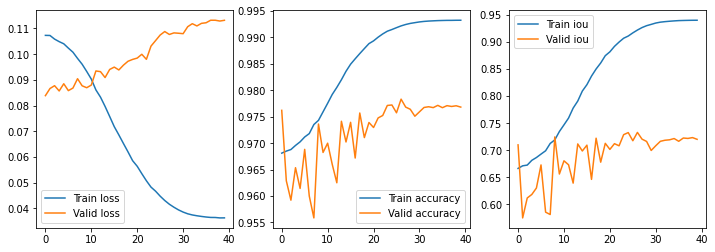

In [ ]:
plt.figure(figsize=(12,4))
plt.subplot(131)
plt.plot(history.epoch, history.history["loss"], label="Train loss")
plt.plot(history.epoch, history.history["val_loss"], label="Valid loss")
plt.legend()
plt.subplot(132)
plt.plot(history.epoch, history.history["accuracy"], label="Train accuracy")
plt.plot(history.epoch, history.history["val_accuracy"], label="Valid accuracy")
plt.legend()
plt.subplot(133)
plt.plot(history.epoch, history.history["mean_iou"], label="Train iou")
plt.plot(history.epoch, history.history["val_mean_iou"], label="Valid iou")
plt.legend()
plt.show()

We can generate the y_pred and y_true arrays to hold the target values (predicted and actual) for all the validation data points.
Based on the actual and predicted target values, we can display the confusion matrix as below.


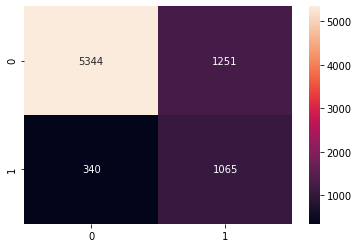


Below is the classification report based on the actual and predicted target values.
              precision    recall  f1-score   support

           0       0.94      0.81      0.87      6595
           1       0.46      0.76      0.57      1405

    accuracy                           0.80      8000
   macro avg       0.70      0.78      0.72      8000
weighted avg       0.86      0.80      0.82      8000



In [ ]:
print('We can generate the y_pred and y_true arrays to hold the target values (predicted and actual) for all the validation \
data points.')
y_pred = []
y_true = []

for imgs, masks, targets in validation_data_generator_box:
    predictions = model.predict(imgs)
    
    # Loop through the predictions along with the actual targets
    for img, mask, prediction, target in zip(imgs, masks, predictions, targets):
        # Apply threshold to the predicted mask
        comp = prediction[:,:,0] > 0.5
        
        # Apply connected components.
        comp = measure.label(comp)
        
        # Take the initial prediction as 0
        predTarget = 0
        
        # Apply bounding boxes
        for region in measure.regionprops(comp):
            # If a region is found mark the target value as 1
            predTarget = 1
            
        y_pred.append(predTarget)
        y_true.append(target)
        
print('Based on the actual and predicted target values, we can display the confusion matrix as below.')
from sklearn.metrics import confusion_matrix, classification_report
cm = confusion_matrix(y_true, y_pred)
ax = sns.heatmap(cm, annot=True, fmt='d')
plt.show()

print('\nBelow is the classification report based on the actual and predicted target values.')
print(classification_report(y_true, y_pred, labels=[0,1])) 

We can now analyze the predictions on the validation data.


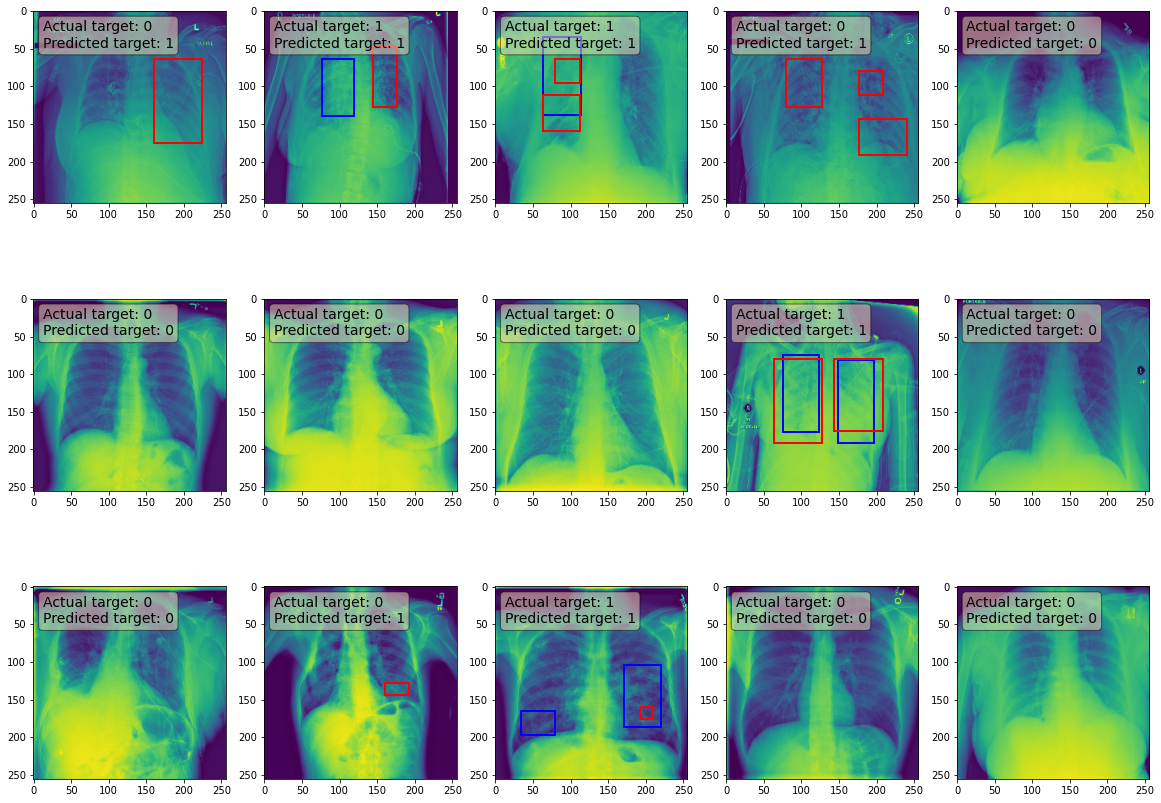

In [ ]:
print('We can now analyze the predictions on the validation data.')
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
for imgs, masks, targets in validation_data_generator_box:
    # Predict a batch of images
    predictions = model.predict(imgs)
    # Create a plot for the images
    fig, axes = plt.subplots(3, 5, figsize=(20, 15))
    axes = axes.ravel()
    axidx = 0A
    
    # Loop through the batch
    for img, mask, prediction, target in zip(imgs, masks, predictions, targets):
        axes[axidx].imshow(img[:,:,0])
        
        # Apply threshold to true mask
        comp = mask[:,:,0] > 0.5
        
        # Apply connected components.
        comp = measure.label(comp)
        
        # Apply bounding boxes
        for region in measure.regionprops(comp):
            y1, x1, y2, x2 = region.bbox
            height = y2-y1
            width = x2-x1
            axes[axidx].add_patch(patches.Rectangle((x1, y1), width, height, linewidth=2, edgecolor='b', facecolor='none'))
            
        # Apply threshold to the predicted mask
        comp = prediction[:,:,0] > 0.5
        
        # Apply connected components.
        comp = measure.label(comp)
        
        predTarget = 0
        
        # Apply bounding boxes
        for region in measure.regionprops(comp):
            # If a region is found mark the target value as 1
            predTarget = 1
            y1, x1, y2, x2 = region.bbox
            height = y2-y1
            width = x2-x1
            axes[axidx].add_patch(patches.Rectangle((x1, y1), width, height, linewidth=2, edgecolor='r', facecolor='none'))
        
        axes[axidx].text(0.05, 0.95, f'Actual target: {target} \nPredicted target: {predTarget}', transform=axes[axidx].transAxes, fontsize=14, verticalalignment='top', bbox=props)
        axidx += 1
        if(axidx >= 15):
            break;
        
    plt.show()
    
    # Display only one plot per batch
    break